# 데이터 불러오기 및 기본 정보 확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import get_window, welch, spectrogram
from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

# 샘플링 주파수 설정
fs = 100  # Hz, 실험 환경에 맞게 조정

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sample_tire_data.csv to sample_tire_data.csv


In [16]:
# 파일 불러오기
file_path = '/content/data.csv'  # Colab에 업로드한 파일 경로
df = pd.read_csv(file_path)

# 시각화

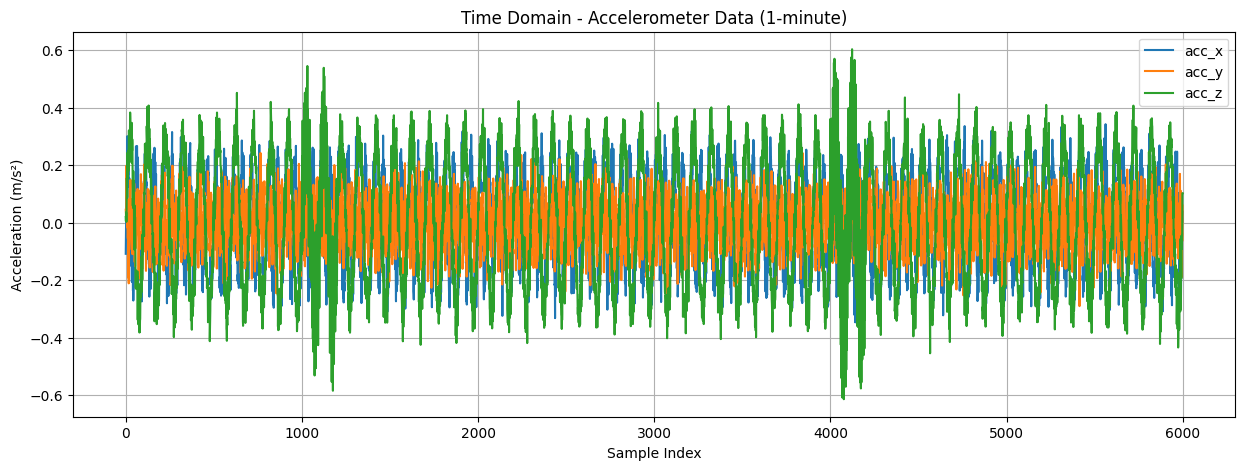

In [ ]:
# 전체 축 시계열 그래프
plt.figure(figsize=(15, 5))
plt.plot(df['acc_x'], label='acc_x')
plt.plot(df['acc_y'], label='acc_y')
plt.plot(df['acc_z'], label='acc_z')
plt.title('Time Domain - Accelerometer Data (1-minute)')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

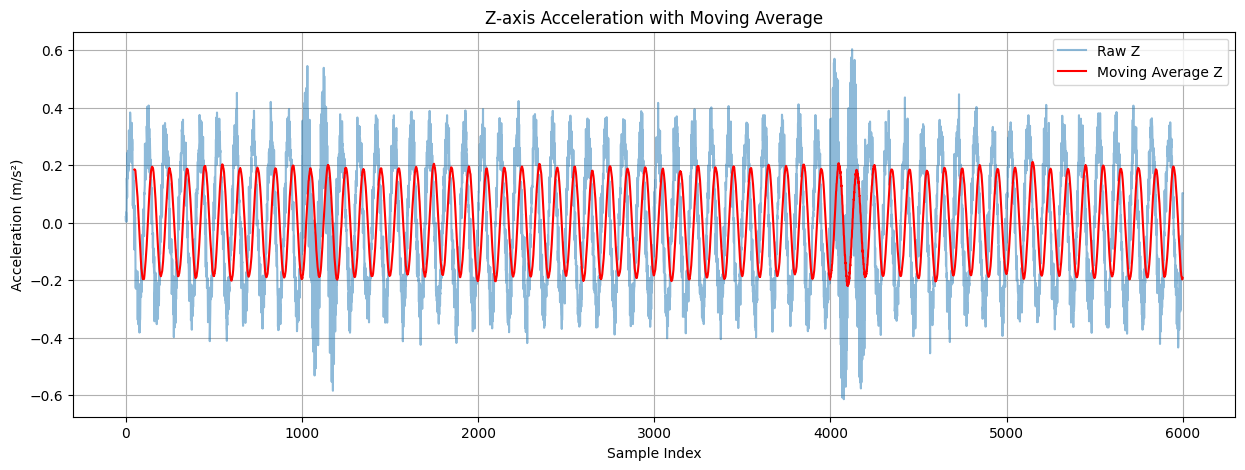

In [ ]:
# 이동 평균 계산
window = 14  # 약 0.5초 기준 (샘플링 주기 35ms 가정)
for axis in ['acc_x', 'acc_y', 'acc_z']:
    df[f'{axis}_ma'] = df[axis].rolling(window=window).mean()

# 시각화
plt.figure(figsize=(15, 5))
plt.plot(df['acc_z'], label='Raw Z', alpha=0.5)
plt.plot(df['acc_z_ma'], label='Moving Average Z', color='red')
plt.title('Z-axis Acceleration with Moving Average')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

# 주파수 분석

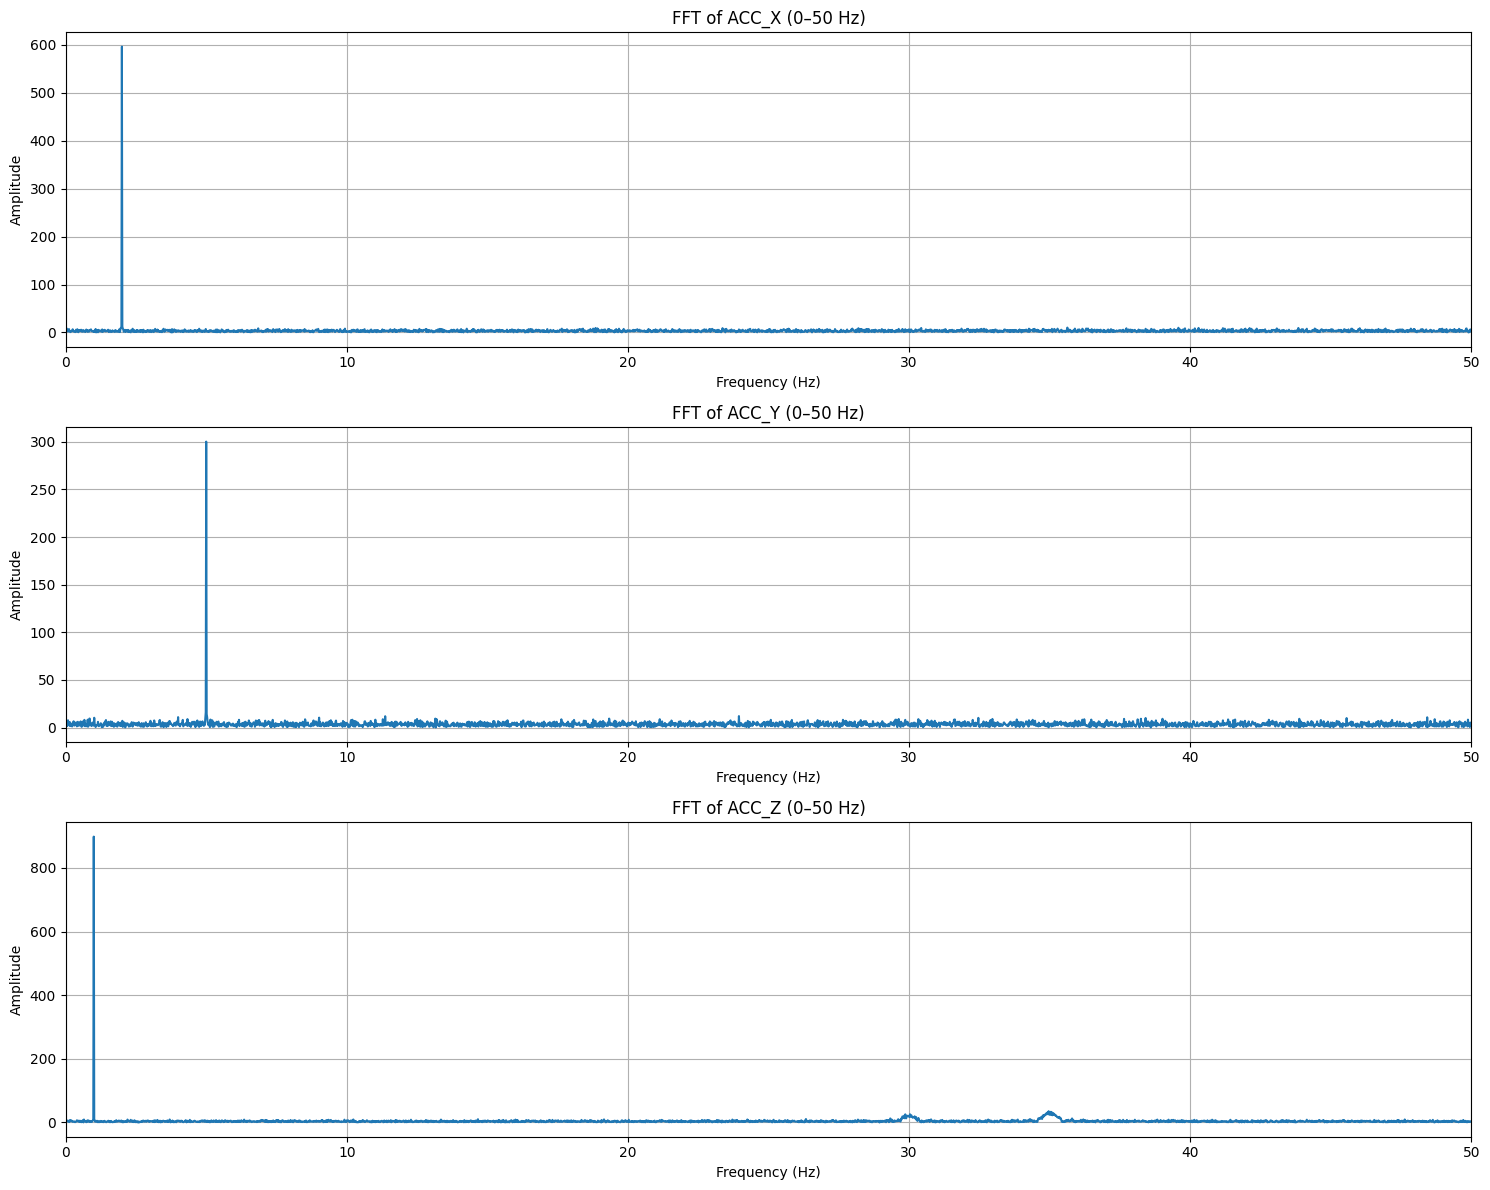

In [ ]:
# 샘플링 주파수 설정 (Hz)
fs = 1000 / 35  # 실제 환경에 맞게 수정

plt.figure(figsize=(15, 12))

for i, axis in enumerate(['acc_x', 'acc_y', 'acc_z']):
    signal = df[axis].values
    n = len(signal)
    freq = rfftfreq(n, d=1/fs)
    fft_vals = np.abs(rfft(signal))

    plt.subplot(3, 1, i+1)
    plt.plot(freq, fft_vals)
    plt.xlim(0, 50)
    plt.title(f'FFT of {axis.upper()} (0–50 Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)

plt.tight_layout()
plt.show()

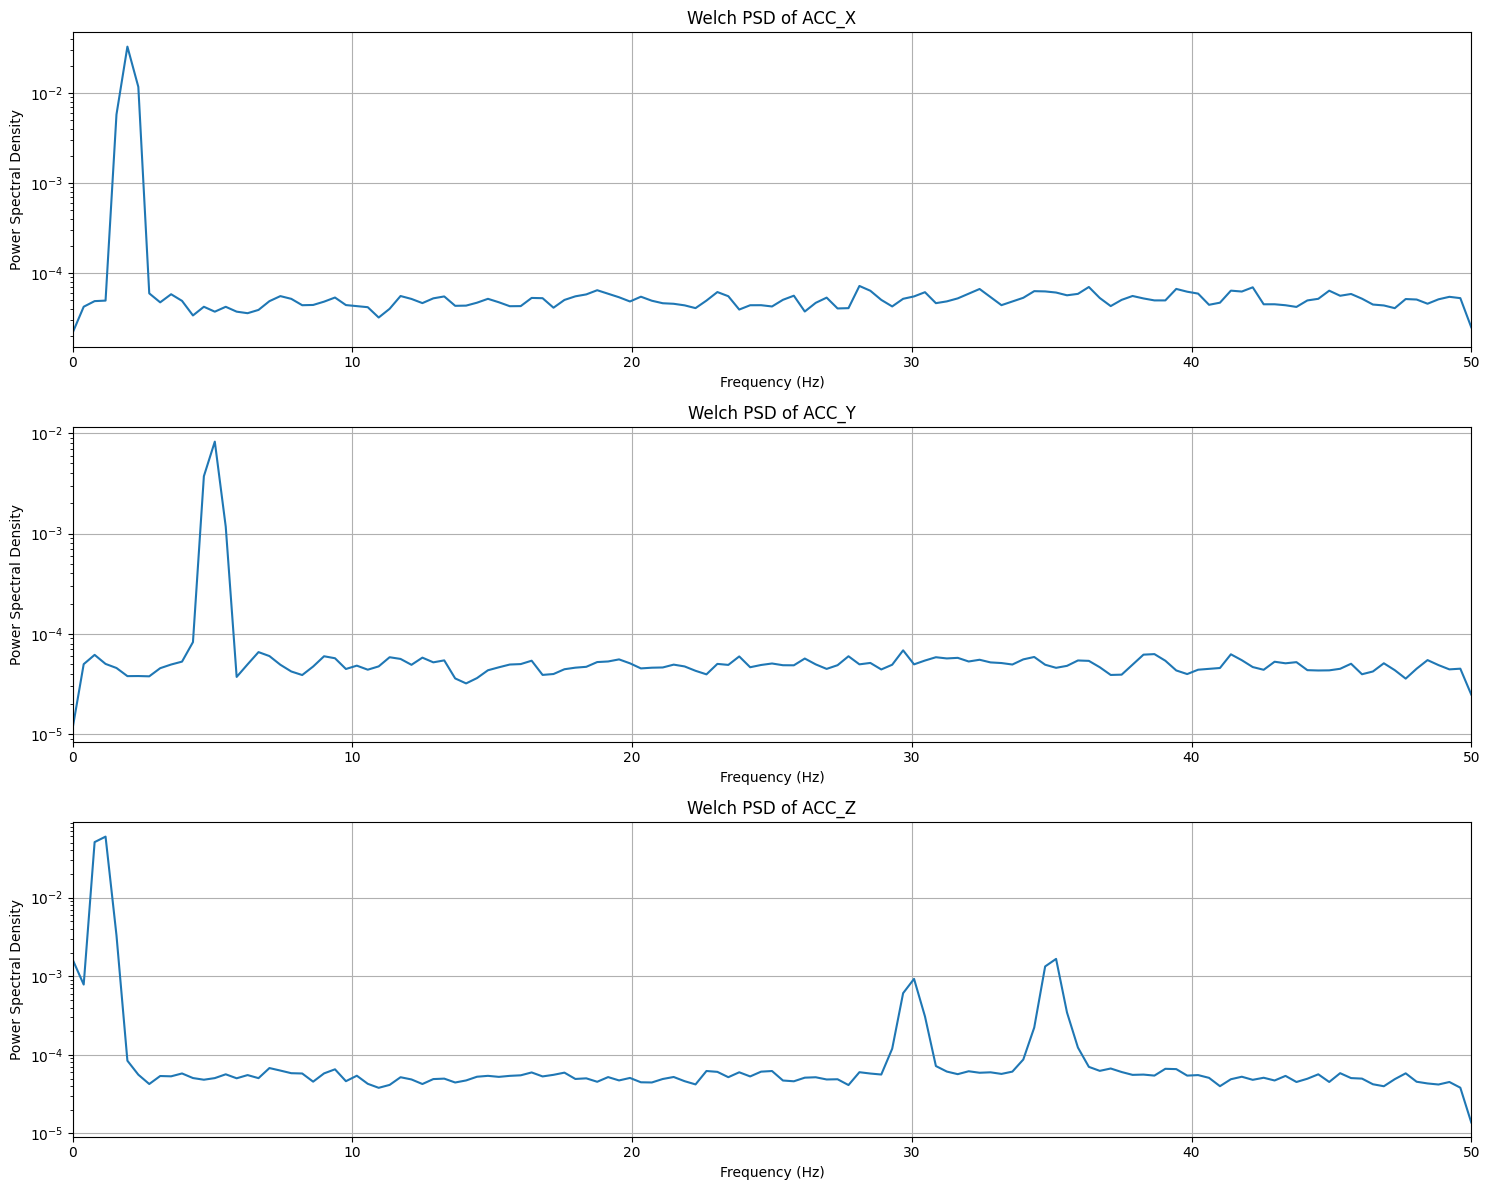

In [ ]:
plt.figure(figsize=(15, 12))

for i, axis in enumerate(['acc_x', 'acc_y', 'acc_z']):
    f, psd = welch(df[axis], fs=fs, nperseg=256)

    plt.subplot(3, 1, i+1)
    plt.semilogy(f, psd)
    plt.title(f'Welch PSD of {axis.upper()}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.xlim(0, 50)
    plt.grid(True)

plt.tight_layout()
plt.show()

# 가속도 값 분포

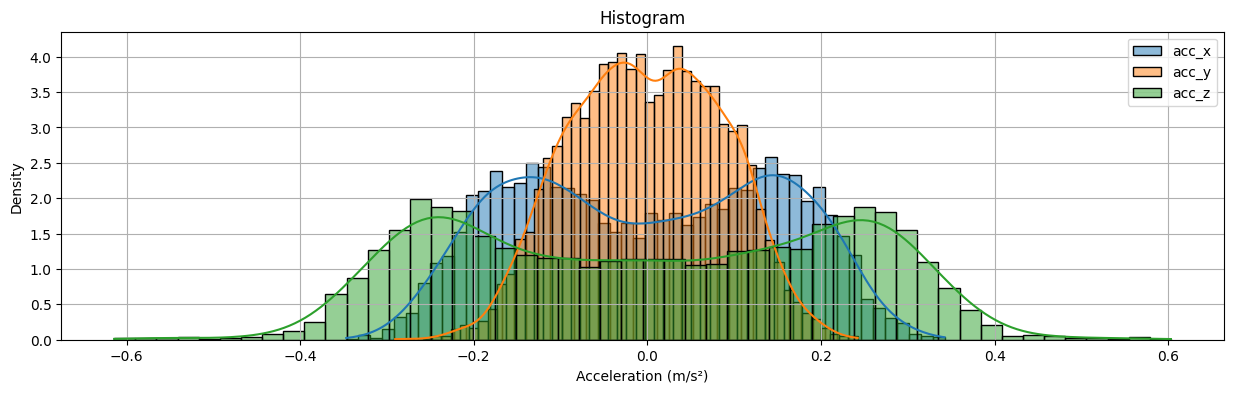

In [ ]:
plt.figure(figsize=(15, 4))

for axis in ['acc_x', 'acc_y', 'acc_z']:
    sns.histplot(df[axis], kde=True, bins=50, label=axis, stat='density')

plt.title('Histogram')
plt.xlabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

# 특징

In [ ]:
def extract_features_all_axes(data, fs=100):
    features = {}
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        signal = data[axis].values
        fft_vals = np.abs(rfft(signal))
        f, psd = welch(signal, fs)

        features[f'{axis}_mean'] = np.mean(signal)
        features[f'{axis}_std'] = np.std(signal)
        features[f'{axis}_min'] = np.min(signal)
        features[f'{axis}_max'] = np.max(signal)
        features[f'{axis}_range'] = features[f'{axis}_max'] - features[f'{axis}_min']
        features[f'{axis}_skew'] = pd.Series(signal).skew()
        features[f'{axis}_kurtosis'] = pd.Series(signal).kurtosis()
        features[f'{axis}_fft_peak'] = np.max(fft_vals)
        features[f'{axis}_fft_energy'] = np.sum(fft_vals**2)
        features[f'{axis}_spectral_entropy'] = entropy(fft_vals / np.sum(fft_vals + 1e-12))
        features[f'{axis}_psd_mean_freq'] = np.sum(f * psd) / np.sum(psd)

    return pd.DataFrame([features])

features_df = extract_features_all_axes(df, fs=fs)
print("추출된 특징 요약:")
display(features_df)

추출된 특징 요약:


,acc_x_mean,acc_x_std,acc_x_min,acc_x_max,acc_x_range,acc_x_skew,acc_x_kurtosis,acc_x_fft_peak,acc_x_fft_energy,acc_x_spectral_entropy,...,acc_z_std,acc_z_min,acc_z_max,acc_z_range,acc_z_skew,acc_z_kurtosis,acc_z_fft_peak,acc_z_fft_energy,acc_z_spectral_entropy,acc_z_psd_mean_freq
0,-0.000461,0.149168,-0.346876,0.342367,0.689244,0.002774,-1.183942,595.91445,400546.42096,7.648835,...,0.222481,-0.614276,0.603145,1.217421,-0.005709,-1.190511,898.606482,890985.352009,7.480663,3.565995
